## Imports

In [87]:
# Conv2D is spatial convolution over images
# MaxPooling2D is a max pooling operation for 2D spatial data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# sequential is good for when we have a single dataset and looking for single output
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
import tensorflow as tf
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Data collection and gpu configuration

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
     

# removing dodgy images
# open computer vision
# allows us to check extensions of images

# variable to data directory
data_dir = 'tonsildb'

# extensions of images
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

data = tf.keras.utils.image_dataset_from_directory('tonsildb', seed=42)
images_np = np.concatenate([x for x, y in data], axis=0)
labels_np = np.concatenate([y for x, y in data], axis=0)

## Available pre processing pipeline functions

In [ ]:
def color_correct(image):
    image = tf.image.adjust_contrast(image, contrast_factor=1.5)
    image = tf.image.adjust_brightness(image, delta=0.2)
    image = tf.clip_by_value(image, 0, 255)
    # image = tf.cast(image, tf.float32)/255.0
    return image


def rgb_to_ycbcr(rgb_image):
    R, G, B = tf.split(rgb_image, num_or_size_splits=3, axis=-1)
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.169 * R - 0.331 * G + 0.5 * B + 128
    Cr = 0.5 * R - 0.419 * G - 0.081 * B + 128
    ycbcr_image = tf.stack([Y, Cb, Cr], axis=3)
    ycbcr_image = tf.squeeze(ycbcr_image, axis=-1)
    return ycbcr_image


def color_mask_ycbcr(ycbcr_image):
    y, cb, cr = tf.split(ycbcr_image, num_or_size_splits=3, axis=-1)
    y_min = 92
    y_max = 145
    cb_min = 112
    cb_max = 142
    cr_min = 135
    cr_max = 185
    y_mask = tf.math.logical_and(y >= y_min, y <= y_max)
    cb_mask = tf.math.logical_and(cb >= cb_min, cb <= cb_max)
    cr_mask = tf.math.logical_and(cr >= cr_min, cr <= cr_max)
    color_mask = tf.math.logical_and(
        tf.math.logical_and(y_mask, cb_mask), cr_mask)
    color_mask = tf.cast(color_mask, dtype=tf.float32)
    masked_image = ycbcr_image * color_mask
    # masked_image = tf.cast(masked_image, tf.float32)/255.0
    return masked_image

def color_mask_rgb(rgb_image):
    #print_rgb_channel_values(rgb_image)
    r, g, b = tf.split(rgb_image, num_or_size_splits=3, axis=-1)
    r_min = 0
    r_max = 320
    g_min = 0
    g_max = 320
    b_min = 0
    b_max = 320
    r_mask = tf.math.logical_and(r >= r_min, r <= r_max)
    g_mask = tf.math.logical_and(g >= g_min, g <= g_max)
    b_mask = tf.math.logical_and(b >= b_min, b <= b_max)
    color_mask = tf.math.logical_and(
        tf.math.logical_and(r_mask, g_mask), b_mask)
    color_mask = tf.cast(color_mask, dtype=tf.float32)
    masked_image = rgb_image * color_mask
    # masked_image = tf.cast(masked_image, tf.float32)/255.0
    return masked_image


## Pipeline

In [ ]:
def pipeline_for_individial_image(image):
    image = color_correct(image=image)
    image = rgb_to_ycbcr(rgb_image=image)
    return image

def pipeline(data):
    data = data.map(lambda x, y: (color_correct(x), y))
    #data = data.map(lambda x, y: (color_mask_rgb(x), y))
    #data = data.map(lambda x, y: (rgb_to_ycbcr(x), y))
    #data = data.map(lambda x, y: (color_mask_ycbcr(x), y))
    return data

data = pipeline(data)

## See what color correct does

In [ ]:
color_corrected_data = data.map(lambda x, y: (color_correct(x), x, y))
for color_corrected_batch, original_batch, label_batch in color_corrected_data.take(1):
    for i in range(32):
        plt.subplot(4, 16, i*2 + 1)
        plt.imshow(original_batch[i]/255.0)
        plt.axis('off')
        plt.subplot(4, 16, i*2 + 2)
        plt.imshow(color_corrected_batch[i]/255.0)
        plt.axis('off')
    plt.show()

## Extracting data using opencv

In [100]:
image_directory = 'tonsildb/'
dataset = []
label = []

no_pha_images = os.listdir(image_directory+'no_pharyngitis')
for i, image_name in enumerate(no_pha_images):    #Remember enumerate method adds a counter and returns the enumerate object
    image = cv2.imread(image_directory + 'no_pharyngitis/' + image_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((256, 256))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dataset.append(image)
    label.append(0)


pha_images = os.listdir(image_directory + 'pharyngitis/')
for i, image_name in enumerate(pha_images):    #Remember enumerate method adds a counter and returns the enumerate object
    image = cv2.imread(image_directory + 'pharyngitis/' + image_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((256, 256))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dataset.append(image)
    label.append(1)
    
images_np = dataset
labels_np = label

## Augmenting the data functions

In [101]:
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img

def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img


def horizontal_flip(img):    
    return cv2.flip(img, 1)
    

## Augmentation pipeline

In [102]:
def brightness_and_flip(image_np):
    image_np = horizontal_flip(image_np)
    image_np = brightness(image_np, 0.7, 1.2)
    return image_np


for i in range(len(images_np)):
    to_append = horizontal_flip(images_np[i])
    images_np.append(to_append)
    labels_np.append(labels_np[i])
    to_append = brightness(images_np[i], 0.7, 1.2)
    images_np.append(to_append)
    labels_np.append(labels_np[i])
    to_append = brightness_and_flip(images_np[i])
    images_np.append(to_append)
    labels_np.append(labels_np[i])
    
print(len(images_np))
print(len(labels_np))

1448
1448


## OpenCV pipeline functions

In [91]:
def print_image(image_np):
    plt.imshow(image_np/255.0)
    plt.show()

def print_image_grayscale(image_np, gray = False):
    if gray == True:
        plt.imshow(image_np/255.0, cmap='gray')
    else:
        plt.imshow(image_np)
    plt.show()

def combine_mask_with_image(mask, image_np):
    image_np = cv2.bitwise_and(image_np, image_np, mask = mask)
    return image_np


def apply_threshold_rgb(images_np, lower = np.array([0,0,0]), upper = np.array([255,255,255])):
    binary_np = cv2.inRange(images_np, lower, upper)
    return binary_np


def apply_threshold_grayscale(grayscale_np, lower=0, upper=255):
    binary_np = cv2.inRange(grayscale_np, lower, upper)
    return binary_np

def convert_to_grayscale(images_np):
    #gray_np = np.dot(images_np[..., :3], [0.2989, 0.5870, 0.1140])
    gray_np = cv2.cvtColor(images_np, cv2.COLOR_BGR2GRAY)
    return gray_np

def convert_rgb_to_ycbcr(image_np):
    image_np = image_np.astype(np.uint8)
    ycbcr_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2YCrCb)
    return ycbcr_image

def resize_image(image_np, new_size):
    resize_image = cv2.resize(image_np, new_size)
    return resize_image

def color_normalisation(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    mean_s = np.mean(s)
    std_s = np.std(s)
    mean_v = np.mean(v)
    std_v = np.std(v)
    
    s_norm = (s-mean_s)/std_s
    v_norm = (v-mean_v)/std_v
    
    hsv[:,:,1] = s_norm
    hsv[:,:,2] = v_norm
    img_norm = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_norm
    
    
    
'''
def transform_using_watershed(grad_mag_np, image_np, labels_np):
    grad_mag_np = cv2.convertScaleAbs(grad_mag_np)
    ret, thresh = cv2.threshold(grad_mag_np, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    
    
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = markers.astype('int32')
    image_np = cv2.convertScaleAbs(image_np)
    markers = cv2.watershed(image_np, markers)
    img_output = np.zeros_like(image_np)
    img_output[markers == -1] = 255
    plt.imshow(img_output)
    plt.show()
'''

"\ndef transform_using_watershed(grad_mag_np, image_np, labels_np):\n    grad_mag_np = cv2.convertScaleAbs(grad_mag_np)\n    ret, thresh = cv2.threshold(grad_mag_np, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)\n    kernel = np.ones((3,3), np.uint8)\n    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)\n    sure_bg = cv2.dilate(opening, kernel, iterations=3)\n    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)\n    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)\n    sure_fg = np.uint8(sure_fg)\n    unknown = cv2.subtract(sure_bg, sure_fg)\n    ret, markers = cv2.connectedComponents(sure_fg)\n    \n    \n    markers = markers + 1\n    markers[unknown == 255] = 0\n    markers = markers.astype('int32')\n    image_np = cv2.convertScaleAbs(image_np)\n    markers = cv2.watershed(image_np, markers)\n    img_output = np.zeros_like(image_np)\n    img_output[markers == -1] = 255\n    plt.imshow(img_output)\n    plt.show()\n"

## Image segmentation functions

In [92]:
def neighbourhood_region_labelling(np_binary_image):
    #labels is a numpy array that contains the labelled image. Each pixel is assigned a label value corresponding to the inex of the connected component that pixel belongs to
    #num_labels is an integer representing number of connected components
    num_labels, labels = cv2.connectedComponents(np_binary_image, connectivity=8)
    return labels

## Edge detection and smoothing functions

In [93]:
def apply_gaussian_blur(images_np):
    # second argument is kernel size. Larger the kernel size means wider distribution of weights
    # third argument is sigma - larger the sigma the more spread out the blur effect. Pixels far away have greater influence on final output
    # A larger kernel size can help to smooth out larger features in the image, while a larger sigma value can help to remove finer details and noise
    blurred_image_np = cv2.GaussianBlur(images_np, (7, 7), 15)
    return blurred_image_np

def calculate_gradient_mag_using_sobel(grayscale_np):
    #Second argument is the data type of the output gradient image
    #Third - Order of derivative in x direction
    #Fourth - Order of derivative in y direction
    #Fifth - Sobel Kernel to be used in convolution
    grad_x = cv2.Sobel(grayscale_np, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(grayscale_np, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return grad_mag

def calculate_gradient_mag_using_canny(grayscale_np, lower_thresh = 0, upper_thresh = 0):
    #second argument - grad mag threshold. Any edge with grad mag lower than this is discarded as weak edges
    #third argument - grad mag threshold but any edge with grad mag higher considered as strong edges
    grayscale_np = grayscale_np.astype(np.uint8)
    edges_np = cv2.Canny(grayscale_np,lower_thresh, upper_thresh)
    return edges_np


def get_contours_from_binary_edges(edges):
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours

## Vision modelling and detecting shapes

In [94]:

def get_circles_from_edges(edges, min_radius = 0, max_radius = 100):
    #first argument is the binary image of edges
    #Second argument is variation of hough transform -
    #variants include cv2.HOUGH_STANDARD, cv2.HOUGH_PROBABALISTIC, cv2.HOUGH_GRADIENT
    #third argument is resolution of accumulator array - represents ratio between image resolution and resolution of accumulator array - determines granularity of search - smaller leads to more finer search
    #fourth argument is the minimum distance between centers of detected circles
    #param1 is the higher threshold for the canny edge detector
    #fourth argument is Min and max radius of circles found
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1,20, param1=50, param2= 30, minRadius=min_radius, maxRadius=max_radius)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        distances = np.sqrt((circles[:, 0] - edges.shape[1]/2)**2 + (circles[:, 1] - edges.shape[0]/2)**2)
        sorted_circles = circles[np.argsort(distances)]
        sorted_circles = np.expand_dims(sorted_circles, axis=0)
        return sorted_circles
    
    return circles


def draw_circles_on_image(image_np, circles):
    if circles is not None:
        circles = np.uint16(np.around(circles))
        #because of break after this, it will only take the top most circle i.e. closest to centre
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv2.circle(image_np, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = i[2]
            cv2.circle(image_np, center, radius, (255, 0, 255), 3)
            break
    return image_np

def draw_circle_on_image(image_np, circle):
    image_np = cv2.circle(image_np, (circle[0],circle[1]),circle[2],(0,255,0),2)
    return image_np

def create_square_mask(circle, image_np):
    print(circle)
    x, y = circle[:2]
    size = circle[2]
    mask = np.zeros(image_np.shape[:2], dtype=np.uint8)
    mask[y-size:y+size, x-size:x+size] = 1
    return mask

def crop_image(image_np, circle):
    square_size = circle[2] * 2
    x_start = circle[0]-circle[2]
    y_start = circle[1] - circle[2]
    cropped = image_np[y_start: y_start+square_size, x_start:x_start+square_size]
    return cropped


def create_and_apply_circle_mask(image_np, circles):
    if circles is not None:
        circle = circles[0][0]
        mask = np.zeros(image_np.shape[:2], dtype=np.uint8)
        cv2.circle(mask, (circle[0], circle[1]), circle[2], (255, 255, 255), -1)
        circle_result = cv2.bitwise_and(image_np, image_np, mask=mask)
        result = crop_image(circle_result, circle)
    else:
        result = np.zeros_like(image_np)
    return result

## Pipeline

In [103]:
def pipeline(images_np, labels_np):
    images_np, labels_np = apply_gaussian_blur(images_np, labels_np)
    data_from_np = tensor_dataset_from_np(images_np, labels_np)
    
'''    
for i in range(len(images_np)):
    #binary_np= apply_threshold_rgb(images_np[i], np.array([0,0,0]), np.array([250,250,250]))
    #image_np = combine_mask_with_image(binary_np, images_np[i])

    #ycbcr_image = convert_rgb_to_ycbcr(images_np[i])
    #binary_np = apply_threshold_rgb(ycbcr_image, np.array([22,130,110]), np.array([122,155,130]))
    #image_np = combine_mask_with_image(binary_np, images_np[i])
    #print_image(image_np)
    
    
    blurred_np= apply_gaussian_blur(images_np[i])
    #print_image(blurred_np)
    gray_np = convert_to_grayscale(blurred_np)
    #print_image_grayscale(gray_np)
    #grad_mag_np = calculate_gradient_mag_using_sobel(gray_np)
    #print_image_grayscale(grad_mag_np, True)
    grad_mag_np = calculate_gradient_mag_using_canny(gray_np, 0, 5)
    #grad_mag_np = canny_skimage(gray_np)
    circles = get_circles_from_edges(grad_mag_np, 70, 100)S
    cropped_image_np = create_and_apply_circle_mask(images_np[i],circles)
    images_np[i] = resize_image(cropped_image_np, (256,256))
    maxes.append(np.amax(images_np[i]))
    images_np[i] = images_np[i].astype('float32')/255.0
    maxes_new.append(np.amax(images_np[i]))
    #circles_np = draw_circle_on_image(to_draw_np, circles)
    #circles_np = draw_circles_on_image(to_draw_np, circles)
    #print_image(circles_np)
    #perform_hough_transform(grad_mag_np, images_np[i])
    #transform_using_watershed(grad_mag_np, images_np[i], labels_np[i])
'''
    
for i in range(len(images_np)):
    #color_corrected = color_normalisation(images_np[i])
    #print_image(color_corrected)
    blurred_np= apply_gaussian_blur(images_np[i])
    gray_np = convert_to_grayscale(blurred_np)
    grad_mag_np = calculate_gradient_mag_using_canny(gray_np, 0, 5)
    circles = get_circles_from_edges(grad_mag_np, 70, 100)
    cropped_image_np = create_and_apply_circle_mask(images_np[i],circles)
    images_np[i] = resize_image(cropped_image_np, (256,256))
    images_np[i] = images_np[i].astype('float32')/255.0
    

## Splitting into train and test

In [104]:
#for i in range(len(images_np)):
#    images_np[i] = images_np[i]/255.0


stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(stratified_split.split(images_np, labels_np))

x_train = [images_np[i] for i in train_indices]
y_train = [labels_np[i] for i in train_indices]
x_test = [images_np[i] for i in test_indices]
y_test = [labels_np[i] for i in test_indices]

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

## Building the deep learning model

In [106]:
'''
model = ResNet50(include_top=False, weights='imagenet',
                 input_shape=(256, 256, 3), classes=2, pooling='avg')
resnet_model = Sequential()
resnet_model.add(model)
for layer in resnet_model.layers:
    layer.trainable = False
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
resnet_model.summary()
'''

model = Sequential()
# model.add(resnet_model)
# Conv2D(No. of filters, dimensions of filter, activation function, expected image size(only first time))
model.add(Conv2D(32, (3, 3), 1, activation='relu',
          padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Conv2D(32, (3, 3), 1, activation='relu'))

model.add(Conv2D(32, (3, 3), 1, activation='relu', padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
# model.summary()

In [105]:
del model

## Fitting and testing the model

In [107]:
'''
hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1
)
'''
hist = model.fit(x_train,
    y_train,
    batch_size=32,
    epochs=12,
    validation_split = 0.2,
    verbose=1
)

Epoch 1/12


2023-03-15 10:44:34.063259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 0.8562 - accuracy: 0.5724

2023-03-15 10:44:41.640797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 9s 246ms/step - loss: 0.8562 - accuracy: 0.5724 - val_loss: 0.7013 - val_accuracy: 0.5474
Epoch 2/12
29/29 [==============================] - 6s 206ms/step - loss: 0.6915 - accuracy: 0.5788 - val_loss: 0.6811 - val_accuracy: 0.5474
Epoch 3/12
29/29 [==============================] - 6s 198ms/step - loss: 0.6208 - accuracy: 0.6652 - val_loss: 0.6038 - val_accuracy: 0.6983
Epoch 4/12
29/29 [==============================] - 6s 199ms/step - loss: 0.5825 - accuracy: 0.7073 - val_loss: 0.5990 - val_accuracy: 0.6983
Epoch 5/12
29/29 [==============================] - 6s 200ms/step - loss: 0.5363 - accuracy: 0.7322 - val_loss: 0.5803 - val_accuracy: 0.7241
Epoch 6/12
29/29 [==============================] - 6s 202ms/step - loss: 0.4719 - accuracy: 0.7862 - val_loss: 0.5488 - val_accuracy: 0.7586
Epoch 7/12
29/29 [==============================] - 6s 201ms/step - loss: 0.4318 - accuracy: 0.8121 - val_loss: 0.5232 - val_accuracy: 0.7759
Epoch 8/12
29/29 

### Graph for error and accuracy

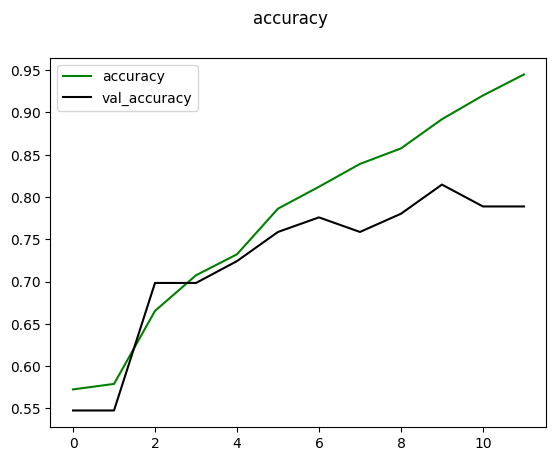

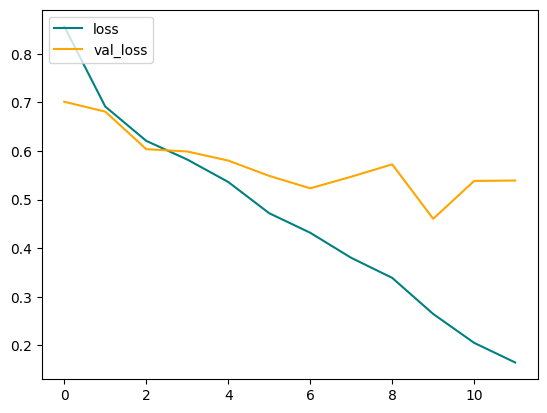

In [108]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='black', label='val_accuracy')
fig.suptitle('accuracy')
plt.legend(loc='upper left')
plt.show()

fig2 = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss')
plt.legend(loc='upper left')
plt.show()

## Evaluation on test set

10/10 [==============================] - 1s 77ms/step


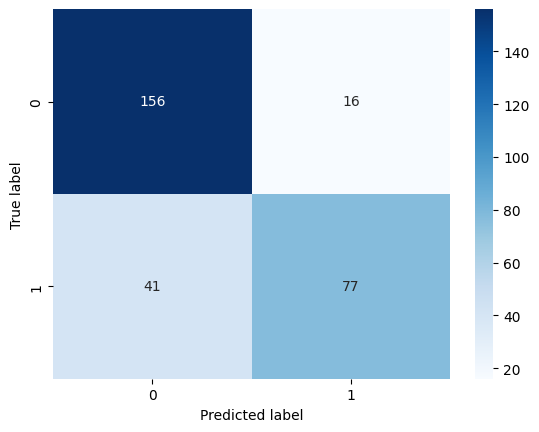

Precision: 0.8279569892473119
Recall: 0.652542372881356
Accuracy: 0.803448275862069


In [126]:
y_preds = model.predict(x_test)
y_preds = np.round(y_preds)
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

## Saving the model

In [ ]:
model.save(os.path.join('models', 'tonsil_detector.h5'))